# 3D patch-based segmentation with U-Net

Code started from [Francesco's tutorials](https://github.com/FrancescoLR/tutorials)



## Setup 


### Imports

In [1]:
import os, sys, shutil, random, tempfile, glob, logging, math, csv
from pathlib import Path
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import seaborn as sns
import pandas as pd
import ignite
import torch, torchvision
import wandb

# MONAI
from monai.config import print_config
from monai.data import ArrayDataset, decollate_batch, DataLoader, CacheDataset, Dataset, PatchDataset, GridPatchDataset, PatchIter, PatchIterd
from monai.data import ImageReader, NumpyReader, NibabelReader, ITKReader, ImageWriter, NibabelWriter, ITKWriter
from monai.handlers.utils import from_engine
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, MeanIoU, compute_meaniou
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.utils import first
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    Compose,
    LoadImaged,
    LoadImage,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    ResizeWithPadOrCropd,
    RandCropByPosNegLabeld,
    Lambdad,
    ScaleIntensityd,
    RandSpatialCropSamples,
    CropForegroundd,
    Invertd,
    SaveImaged,
    RandAffined
)

print_config()

/home/jaimebarranco/miniconda3/envs/3dmultilabel/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.9.1rc3
Numpy version: 1.22.4
Pytorch version: 1.12.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 7a5de8b7b9db101a431e70ae2aa8ea7ebb8dfffe
MONAI __file__: /home/jaimebarranco/miniconda3/envs/3dmultilabel/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.1+cu116
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### Wandb login and init

In [2]:
num_experiment = '2_3'
wandb_enable = True
if wandb_enable:
    # pip install wandb
    wandb.finish()
    wandb.login()

    # Start a new run to track this script
    wandb.init(
        # User/Team
        entity="jaimebarranco",
        # Set the project where this run will be logged
        project="a-eye", 
        # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
        name=f"experiment_{num_experiment}", 
        config = {
            "architecture": "CNN",
            "dataset": "A-Eye",
        },
        notes="full images [176, 256, 176] with RandCropByPosNegLabeld",
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jaimebarranco. Use `wandb login --relogin` to force relogin


### Paths and cuda check

In [3]:
main_dir = f'/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_{num_experiment}/'
data_dir = '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/' # train and val
if not os.path.exists(main_dir):
    os.makedirs(main_dir)

print(f"Main directory is: {main_dir}")
[print(f"Data directory is: {data_dir}") if os.path.isdir(data_dir) else print("Check your data directory")]
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

print(torch.cuda.is_available())

Main directory is: /mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_2_3/
Data directory is: /mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/
True


### Sets

#### Divide the data into train, validation and test sets

In [4]:
''' 
num_total_subjects = 35 # total number of subjects
NUM_LABELS = 9 # number of different labels (without background)

# List of subjects taken for the template construction
template_subjects = ['sub-02','sub-03','sub-20','sub-29','sub-33'] # 5

# List of remaining subjects
all_subjects = list() # all the subjects (total)
for i in range(num_total_subjects):
    all_subjects.append('sub-'+str(i+1).zfill(2))

# Sets percentages
# 80-20(%) = 80-10-10 (%): 27, 4, 4 --> 22, 4, 4
# 70-30(%) = 70-15-15 (%): 25, 5, 5 --> 20, 5, 5
# 60-40(%) = 60-20-20 (%): 21, 7, 7 --> 16, 7, 7
OPTION = 1
if OPTION == 1:
    n_remaining_train = 22
    n_remaining_valid = n_remaining_test = 4
elif OPTION == 2:
    n_remaining_train = 20
    n_remaining_valid = n_remaining_test = 5
elif OPTION == 3:
    n_remaining_train = 16
    n_remaining_valid = n_remaining_test = 7

# Train
rem_subs_train = [elem for elem in all_subjects if elem not in template_subjects] # all the subjects except the 5 used to create the template (in registration)
rest_train = random.sample(rem_subs_train, n_remaining_train) # Remaining subjects out of the 5 for the template
train_subs = sorted(template_subjects + rest_train) # Training set subjects
print(f'{len(train_subs)}, {train_subs}')

# Valid
rem_subs_val = [sub for sub in all_subjects if sub not in train_subs] # Remaining subjects (all - training set)
val_subs = sorted(random.sample(rem_subs_val, n_remaining_valid))
print(f'{len(val_subs)}, {val_subs}')

# Test
rem_subs_test = [sub for sub in rem_subs_val if sub not in val_subs] # Remaining subjects (all - training set)
test_subs = sorted(rem_subs_test) # No random (take the remaining ones)
print(f'{len(val_subs)}, {test_subs}')

# Save train subjects
list_train_file = main_dir + 'train_subjects.txt'
with open(list_train_file, 'w') as fp:
    for item in train_subs:
        fp.write("%s\n" % item) # write each item on a new line
    print('Saved val subjects to .txt')

# Save val subjects
list_val_file = main_dir + 'val_subjects.txt'
with open(list_val_file, 'w') as fp:
    for item in val_subs:
        fp.write("%s\n" % item) # write each item on a new line
    print('Saved val subjects to .txt')

# Save test subjects (to inference)
list_test_file = main_dir + 'test_subjects.txt'
with open(list_test_file, 'w') as fp:
    for item in test_subs:
        fp.write("%s\n" % item) # write each item on a new line
    print('Saved test subjects to .txt for later inference')

# wandb config update: sets
if wandb_enable:
    wandb.config.update({
        "train_subjects": train_subs,
        "val_subjects": val_subs,
    })
'''

' \nnum_total_subjects = 35 # total number of subjects\nNUM_LABELS = 9 # number of different labels (without background)\n\n# List of subjects taken for the template construction\ntemplate_subjects = [\'sub-02\',\'sub-03\',\'sub-20\',\'sub-29\',\'sub-33\'] # 5\n\n# List of remaining subjects\nall_subjects = list() # all the subjects (total)\nfor i in range(num_total_subjects):\n    all_subjects.append(\'sub-\'+str(i+1).zfill(2))\n\n# Sets percentages\n# 80-20(%) = 80-10-10 (%): 27, 4, 4 --> 22, 4, 4\n# 70-30(%) = 70-15-15 (%): 25, 5, 5 --> 20, 5, 5\n# 60-40(%) = 60-20-20 (%): 21, 7, 7 --> 16, 7, 7\nOPTION = 1\nif OPTION == 1:\n    n_remaining_train = 22\n    n_remaining_valid = n_remaining_test = 4\nelif OPTION == 2:\n    n_remaining_train = 20\n    n_remaining_valid = n_remaining_test = 5\nelif OPTION == 3:\n    n_remaining_train = 16\n    n_remaining_valid = n_remaining_test = 7\n\n# Train\nrem_subs_train = [elem for elem in all_subjects if elem not in template_subjects] # all the su

#### Load train and val subjects from file
Instead of doing it randomly all over again. Useful in cases in which we want to repeat the training with the same subjects.

In [4]:
# Train subjects
train_file = main_dir + 'train_subjects.txt' # train subjects list file
train_subs = [] # empty list to read list from a file
# open file and read the content in a list
with open(train_file, 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]
        # add current item to the list
        train_subs.append(x)
# display list
print(train_subs)

# Val subjects
val_file = main_dir + 'val_subjects.txt' # val subjects list file
val_subs = [] # empty list to read list from a file
# open file and read the content in a list
with open(val_file, 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]
        # add current item to the list
        val_subs.append(x)
# display list
print(val_subs)

# wandb config update: sets
if wandb_enable:
    wandb.config.update({
        "train_subjects": train_subs,
        "val_subjects": val_subs,
    })

['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-10', 'sub-11', 'sub-12', 'sub-16', 'sub-17', 'sub-18', 'sub-20', 'sub-22', 'sub-23', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-29', 'sub-30', 'sub-31', 'sub-32', 'sub-33', 'sub-35']
['sub-09', 'sub-15', 'sub-19', 'sub-24']


#### Images and Labels paths

In [5]:
num_total_subjects = 35 # total number of subjects
NUM_LABELS = 9 # number of different labels (without background)

# Sets
train_images = []
train_labels = []
val_images = []
val_labels = []

# Train set
for i in range(len(train_subs)):
    input_t1 = data_dir + 'a123/' + train_subs[i] + '/input/' + train_subs[i] + '_T1.nii.gz'
    input_labels = data_dir + 'a123/' + train_subs[i] + '/input/' + train_subs[i] + '_labels.nii.gz'
    train_images.append(input_t1)
    train_labels.append(input_labels)

# Train dictionary
data_train_dict = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

# Validation set
for i in range(len(val_subs)):
    input_t1 = data_dir + 'a123/' + val_subs[i] + '/input/' + val_subs[i] + '_T1.nii.gz'
    input_labels = data_dir + 'a123/' + val_subs[i] + '/input/' + val_subs[i] + '_labels.nii.gz'
    val_images.append(input_t1)
    val_labels.append(input_labels)

# Validation dictionary
data_val_dict = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(val_images, val_labels)
]

num_train_samples = len(data_train_dict)
num_val_samples = len(data_val_dict)
num_total_samples = num_total_subjects
print(f"Train set is composed by {num_train_samples} subjects ({num_train_samples/num_total_samples*100:.2f}%), \
    \nand Validation set by {num_val_samples} subjects ({num_val_samples/num_total_samples*100:.2f}%)")

Train set is composed by 27 subjects (77.14%),     
and Validation set by 4 subjects (11.43%)


#### Min image size

In [7]:
''' 
Calculate the minimum and maximum axis of a set of images in a specific path
'''

# List of remaining subjects
all_subjects = list() # all the subjects (total)
for i in range(num_total_subjects):
    all_subjects.append('sub-'+str(i+1).zfill(2))

arr = [0, 0, 0] # [xmax, ymax, zmax]

for i in range(35):
    input_t1 = data_dir + 'a123/' + all_subjects[i] + '/input/' + all_subjects[i] + '_T1_cropped.nii.gz'
    n1 = nib.load(input_t1)
    if n1.shape[0] >= arr[0]:
        arr[0] = n1.shape[0]
    if n1.shape[1] >= arr[1]:
        arr[1] = n1.shape[1]
    if n1.shape[2] >= arr[2]:
        arr[2] = n1.shape[2]

print(f'(xmax, ymax, zmax) = ({arr[0]}, {arr[1]}, {arr[2]})')
min_axis = np.amax(arr)
min_axis = 96
print(f'min_axis = {min_axis}')

(xmax, ymax, zmax) = (176, 256, 176)
min_axis = 96


### Transforms and DataLoader

#### Transforms
Several transforms to augment the dataset
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [6]:
# Function to crop the eye from the medical image
def masked(data_dict):
    eye_mask = (data_dict["label"] != 0)
    eye_mask[eye_mask == True] = 1
    eye_mask[eye_mask == False] = 0
    data_dict["image"] = data_dict["image"] * eye_mask

    return data_dict

# Transform parameters
# For the ScaleIntensityd
minv = 0
maxv = 1
# For the ResizeWithPadOrCropd
spatial_size_resize = (96, 96, 96)
# For the RandCropByPosNegLabeld
axcodes = "RAS"
pixdim = (1, 1, 1)
mode = ("bilinear", "nearest")
spatial_size_randcrop = (96, 96, 96)
pos = 1
neg = 0
num_samples = 4
# For the RandAffined
rotate_range = (0, 0, np.pi/15)
scale_range=(0.1, 0.1, 0.1)
# shear_range=()
translate_range=(1, 1, 1)

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]), # load image file or files from provided path based on reader.
        Lambdad(keys=["image"], func=lambda image: torch.nan_to_num(image, nan=0)),
        EnsureChannelFirstd(keys=["image", "label"]), # ensures the original data to construct "channel first" shape
        ScaleIntensityd(keys=["image"], minv=minv, maxv=maxv), # scale the intensity of input image to the given value range (minv, maxv).
        CropForegroundd(keys=["image", "label"], source_key="image"), # removes all zero borders to focus on the valid area of the images and labels
        Orientationd(keys=["image", "label"], axcodes=axcodes), # unifies the data orientation based on the affine matrix
        Spacingd(keys=["image", "label"], pixdim=pixdim, mode=mode), # adjusts the spacing by pixdim based on the affine matrix
        # ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=spatial_size_resize),
        # masked,
        RandCropByPosNegLabeld( # randomly crop patch samples from big image based on pos / neg ratio. The image centers of negative samples must be in valid body area
            keys=["image", "label"],
            label_key="label",
            spatial_size=spatial_size_randcrop,
            pos=pos, # pos / (pos + neg) for the probability to pick a foreground voxel as a center rather than a background voxel.
            neg=neg,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=1.0, spatial_size=spatial_size_resize,
            rotate_range=rotate_range,
            scale_range=scale_range,
            # shear_range=shear_range,
            translate_range=translate_range,
        ),
        # SaveImaged(keys="image", output_dir=main_dir+"train_trans/", output_postfix="trans", resample=False, separate_folder=False),
        # SaveImaged(keys="label", output_dir=main_dir+"train_trans/", output_postfix="trans", resample=False, separate_folder=False)
    ]
)
wb_train_trans = [str(type(train_transforms.transforms[f])).split("'")[1].split(".")[-1] for f in range(len(train_transforms))]
print(wb_train_trans)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        Lambdad(keys=["image"], func=lambda image: torch.nan_to_num(image, nan=0)),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys=["image"], minv=minv, maxv=maxv),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes=axcodes),
        Spacingd(keys=["image", "label"], pixdim=pixdim, mode=mode),
        # ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=spatial_size_resize),
        # masked,
        # SaveImaged(keys="image", output_dir=main_dir+"val_trans/", output_postfix="trans", resample=False, separate_folder=False),
        # SaveImaged(keys="label", output_dir=main_dir+"val_trans/", output_postfix="trans", resample=False, separate_folder=False)
    ]
)
wb_val_trans = [str(type(val_transforms.transforms[f])).split("'")[1].split(".")[-1] for f in range(len(val_transforms))]
print(wb_val_trans)

['LoadImaged', 'Lambdad', 'EnsureChannelFirstd', 'ScaleIntensityd', 'CropForegroundd', 'Orientationd', 'Spacingd', 'RandCropByPosNegLabeld', 'RandAffined']
['LoadImaged', 'Lambdad', 'EnsureChannelFirstd', 'ScaleIntensityd', 'CropForegroundd', 'Orientationd', 'Spacingd']


#### wandb config update: transforms

In [7]:
if wandb_enable:
    wandb.config.update({
        "train_transforms": wb_train_trans,
        "val_transforms": wb_val_trans,
        "axcodes": axcodes,
        "pixdim": pixdim,
        "mode": mode,
        "spatial_size_randcrop": spatial_size_randcrop,
        "pos": pos,
        "neg": neg,
        "num_samples": num_samples,
        "spatial_size_resize": spatial_size_resize,
        "minv": minv,
        "maxv": maxv,
        "rotate_range": rotate_range,
        "scale_range": scale_range,
        # "shear_range": shear_range,
        "translate_range": translate_range
    })

#### CacheDataset and DataLoader for training and validation
Here we use CacheDataset to accelerate training and val process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to try the regular Dataset, just change to use the commented code below.

In [8]:
train_ds = CacheDataset(
    data=data_train_dict, transform=train_transforms, cache_rate=1.0, num_workers=8)
# train_ds = Dataset(data=train_files, transform=train_transforms)
# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_batch_size = 2
train_loader = DataLoader(train_ds, batch_size=train_batch_size, num_workers=8)

val_ds = CacheDataset(
    data=data_val_dict, transform=val_transforms, cache_rate=1.0, num_workers=8)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_batch_size = 1
val_loader = DataLoader(val_ds, batch_size=val_batch_size, num_workers=8)

Loading dataset: 100%|██████████| 4/4 [00:00<00:00, 10.53it/s]


#### Check transforms in DataLoader

image shape: (8, 1, 96, 96, 96), label shape: (8, 1, 96, 96, 96)
torch unique label: 9


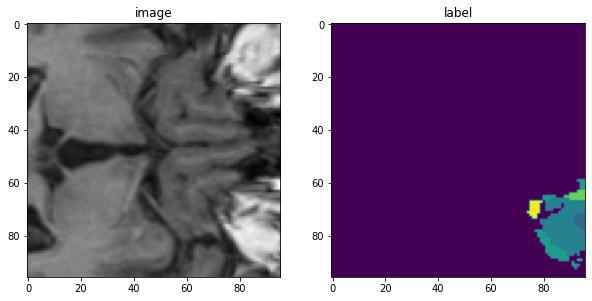

In [11]:
check_data = first(train_loader)
image, label = (check_data["image"], check_data["label"])
print(f"image shape: {image.shape}, label shape: {label.shape}")
print(f'torch unique label: {len(torch.unique(label))}')

plt.figure("check", (10,5))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0, 0, :, :, 48], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, 0, :, :, 48])
plt.show()

# Save transformed image
# im_trans = sitk.GetImageFromArray(np.transpose(image[0].detach().cpu().numpy(), (3,2,1,0)))
# sitk.WriteImage(im_trans, main_dir+'im_trans.nii.gz')
# lab_trans = sitk.GetImageFromArray(np.transpose(label[0].detach().cpu().numpy(), (3,2,1,0)))
# sitk.WriteImage(lab_trans, main_dir+'lab_trans.nii.gz')

#### Save transformed sets

In [26]:
'''
output_dir = main_dir+'val_trans/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Saving check_loader images
i = 1
for _, dict in enumerate(val_loader):
    # print(f"dict: {dict['image'].shape}")
    im_tensors = dict['image']
    lab_tensors = dict['label']
    # print(im_tensors[0].detach().cpu().numpy().shape)
    # print(lab_tensors[0].detach().cpu().numpy().shape)
    im_trans = sitk.GetImageFromArray(np.transpose(im_tensors[0].detach().cpu().numpy(), (3,2,1,0)))
    sitk.WriteImage(im_trans, output_dir+'im_trans'+str(i)+'.nii.gz')
    lab_trans = sitk.GetImageFromArray(np.transpose(lab_tensors[0].detach().cpu().numpy(), (3,2,1,0)))
    sitk.WriteImage(lab_trans, output_dir+'lab_trans'+str(i)+'.nii.gz')
    i += 1
    # if i == 1:
    #     break
# '''

## Training

### Tuning parameters

In [13]:
# Model parameters
model = "UNet"
spatial_dims = 3
in_channels = 1
out_channels = NUM_LABELS+1 # +1 = background
channels = (16, 32, 64, 128, 256)
strides = (2, 2, 2, 2) # why using a stride of 2x2x2 and not 1x1x1 ? 
num_res_units = 2
norm = Norm.BATCH
# dropout = 0.5

# Loss function
loss_function = DiceLoss(to_onehot_y=True, softmax=True)

# Optimizer
optimizer = "Adam"
learning_rate = 1e-3

# Metrics
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Train parameters
max_epochs = 150
val_interval = 5

### Model, Loss, Optimizer

In [14]:
# Create UNet, DiceLoss and Adam optimizer
import gc 
gc.collect()
torch.cuda.empty_cache()
device = torch.device("cuda:0")
model = UNet(
    spatial_dims = spatial_dims,
    in_channels = in_channels,
    out_channels = out_channels,
    channels = channels,
    strides = strides,
    num_res_units = num_res_units,
    norm = norm,
    # dropout = 0.5 # 0.5 is a little bit high (but it depends on how much data you have v.s. how much parameters your network has)
).to(device)

loss_function = loss_function
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate) # The loss seems to go a bit abruptly in the beginning so maybe reducing the learning rate

### wandb config update: model

In [15]:
# Track hyperparameters and run metadata
if wandb_enable:
    wandb.config.update({
        "model": model,
        "spatial_dims": spatial_dims,
        "in_channels": in_channels,
        "out_channels": out_channels,
        "channels": channels,
        "strides": strides,
        "num_res_units": num_res_units,
        "norm": norm, 
        "loss_function": loss_function,
        "optimizer": optimizer,
        "learning_rate": learning_rate,
        "epochs": max_epochs,
        "batch_size": train_batch_size,
        "val_interval": val_interval
    })

### Train loop

In [16]:
FILE = "best_metric_model.pth" # file to save the model

# Initialize values
best_metric = -1
best_metric_epoch = -1
epoch_train_loss_values = []
epoch_val_loss_values = []
metric_values = []

# Post transforms to compute the metrics
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=NUM_LABELS+1)])
post_label = Compose([AsDiscrete(to_onehot=NUM_LABELS+1)])

# Train loop
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    if wandb_enable: wandb.log({"epoch": epoch+1})
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )

        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        if wandb_enable: wandb.log({"train_loss_step": float("{:.4f}".format(epoch_loss))})
        print(
            f"{step}/{math.ceil(len(train_ds) / train_loader.batch_size)}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_train_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    if wandb_enable:
        wb_epoch_loss = epoch_loss
        wandb.log({"avg_train_loss_epoch": float("{:.4f}".format(wb_epoch_loss))})

    # Validation
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            step_val = 0
            epoch_val_loss = 0
            if wandb_enable and epoch+1==max_epochs: table = wandb.Table(columns=['subject', 'image', 'labels', 'pred', 'dice'])
            for j, val_data in enumerate(val_loader):
                step_val += 1
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )

                # Forward pass
                # val_predictions = model(val_inputs)
                # val_loss = loss_function(val_predictions, val_labels)
                # epoch_val_loss += val_loss.item()

                # Inference
                roi_size = spatial_size_resize
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                # compute metric for current iteration
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]  
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)

                if wandb_enable and epoch+1==max_epochs: # just in the last epoch
                    sub_name = val_data['label'][0].as_dict('MetaData')['MetaData_meta_dict']['filename_or_obj'][0].split('/')[-1].split('.')[0].split('_')[0]
                    wb_img = val_data["image"][0, 0, :, :, int(spatial_size_resize[0]/2)].numpy()*255
                    wb_lab = val_data["label"][0, 0, :, :, int(spatial_size_resize[0]/2)].numpy()*255
                    wb_pred = (1 - (val_outputs[0].detach().cpu()[0, :, :, int(spatial_size_resize[0]/2)].numpy().astype(int)))*255
                    table.add_data(sub_name, wandb.Image(wb_img), wandb.Image(wb_lab), wandb.Image(wb_pred), dice_metric.aggregate().item())

            if wandb_enable and epoch+1==max_epochs: wandb.log({"predictions_table": table}, commit=False)
            epoch_val_loss /= step_val
            epoch_val_loss_values.append(epoch_val_loss)
            if wandb_enable: wandb.log({"avg_val_loss_epoch": float("{:.4f}".format(epoch_val_loss))})
            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            if wandb_enable: wandb.log({"avg_val_dice_metric": float("{:.4f}".format(metric))})
            # reset the status for next val round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(main_dir, FILE))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
            if wandb_enable: wandb.log({"best_metric": float("{:.4f}".format(best_metric))})
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

# Mark the run as finished (useful in Jupyter notebooks)
# %wandb  jaimebarranco/a-eye -h 1024 # shows the web interface in the notebook
if wandb_enable: wandb.finish()

----------
epoch 1/150
1/14, train_loss: 0.9787
2/14, train_loss: 0.9743
3/14, train_loss: 0.9698
4/14, train_loss: 0.9658
5/14, train_loss: 0.9608
6/14, train_loss: 0.9557
7/14, train_loss: 0.9499
8/14, train_loss: 0.9456
9/14, train_loss: 0.9448
10/14, train_loss: 0.9387
11/14, train_loss: 0.9379
12/14, train_loss: 0.9306
13/14, train_loss: 0.9260
14/14, train_loss: 0.9232
epoch 1 average loss: 0.9501
----------
epoch 2/150
1/14, train_loss: 0.9139
2/14, train_loss: 0.9100
3/14, train_loss: 0.9022
4/14, train_loss: 0.8969
5/14, train_loss: 0.8905
6/14, train_loss: 0.8842
7/14, train_loss: 0.8815
8/14, train_loss: 0.8754
9/14, train_loss: 0.8761
10/14, train_loss: 0.8634
11/14, train_loss: 0.8583
12/14, train_loss: 0.8519
13/14, train_loss: 0.8428
14/14, train_loss: 0.8439
epoch 2 average loss: 0.8779
----------
epoch 3/150
1/14, train_loss: 0.8264
2/14, train_loss: 0.8202
3/14, train_loss: 0.8114
4/14, train_loss: 0.8106
5/14, train_loss: 0.8070
6/14, train_loss: 0.7976
7/14, train_l

ValueError: This table expects 6 columns: ['subject', 'image', 'labels', 'pred', 'loss', 'dice'], found 5

### Plot the loss and metric

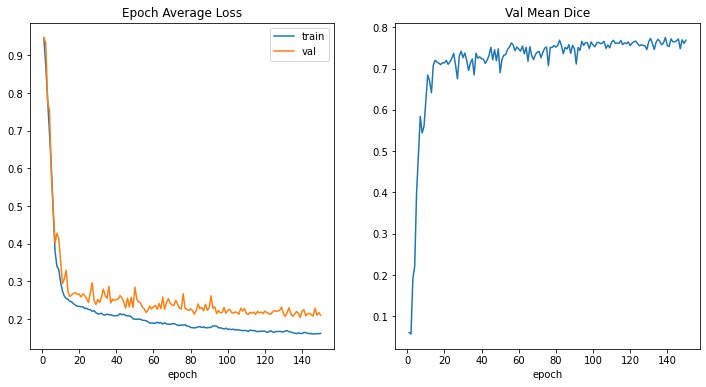

In [18]:
# TODO: plot the graphs live while training with tensorboard
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x1 = [i + 1 for i in range(len(epoch_train_loss_values))]
x2 = [val_interval * (i + 1) for i in range(len(epoch_val_loss_values))]
plt.xlabel("epoch")
plt.plot(x1, epoch_train_loss_values, label="train")
plt.plot(x2, epoch_val_loss_values, label= "val")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Inference

### Common setup

#### Imports

In [1]:
import os, sys, shutil, random, tempfile, glob, logging, math, csv
from pathlib import Path
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import seaborn as sns
import pandas as pd
import ignite
import torch, torchvision

# MONAI
from monai.config import print_config
from monai.data import ArrayDataset, decollate_batch, DataLoader, CacheDataset, Dataset, PatchDataset, GridPatchDataset, PatchIter, PatchIterd
from monai.handlers.utils import from_engine
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, MeanIoU, compute_meaniou
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.utils import first
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    Compose,
    LoadImaged,
    LoadImage,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    ResizeWithPadOrCropd,
    RandCropByPosNegLabeld,
    Lambdad,
    ScaleIntensityd,
    RandSpatialCropSamples,
    CropForegroundd,
    Invertd,
    SaveImaged
)

print_config()

/home/jaimebarranco/miniconda3/envs/3dmultilabel/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.9.1rc3
Numpy version: 1.22.4
Pytorch version: 1.12.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 7a5de8b7b9db101a431e70ae2aa8ea7ebb8dfffe
MONAI __file__: /home/jaimebarranco/miniconda3/envs/3dmultilabel/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.1+cu116
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



#### Paths and cuda check

In [2]:
main_dir = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/'
data_dir = '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/' # train and val

[print(f"Data directory is: {data_dir}") if os.path.isdir(data_dir) else print("Check your data directory")]
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

print(torch.cuda.is_available())

Data directory is: /mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/
True


#### Common variables

In [3]:
num_total_subjects = 35 # total number of subjects
NUM_LABELS = 9 # number of different labels (without background)

#### Min Image size

In [26]:
''' 
Calculate the minimum and maximum axis of a set of images in a specific path
'''

# List of remaining subjects
all_subjects = list() # all the subjects (total)
for i in range(num_total_subjects):
    all_subjects.append('sub-'+str(i+1).zfill(2))

arr = [0, 0, 0] # [xmax, ymax, zmax]

for i in range(35):
    input_t1 = data_dir + 'a123/' + all_subjects[i] + '/input/' + all_subjects[i] + '_T1_cropped.nii.gz'
    n1 = nib.load(input_t1)
    if n1.shape[0] >= arr[0]:
        arr[0] = n1.shape[0]
    if n1.shape[1] >= arr[1]:
        arr[1] = n1.shape[1]
    if n1.shape[2] >= arr[2]:
        arr[2] = n1.shape[2]

print(f'(xmax, ymax, zmax) = ({arr[0]}, {arr[1]}, {arr[2]})')
min_axis = np.amax(arr)
min_axis = 64
print(f'min_axis = {min_axis}')

(xmax, ymax, zmax) = (79, 92, 80)
min_axis = 64


#### Metrics, Device, and Model

In [4]:
# Metrics
dice_metric = DiceMetric(include_background=False, reduction="mean") # Dice
iou_metric = MeanIoU(include_background=False, reduction="mean") # IoU

# Reconfigure model and device (cuda)
device = torch.device("cuda:0")
model = UNet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = NUM_LABELS+1,
    channels = (16, 32, 64, 128, 256),
    strides = (2, 2, 2, 2),
    num_res_units = 2,
    norm = Norm.BATCH,
    # dropout = 0.5 # 0.5 is a little bit high (but it depends on how much data you have v.s. how much parameters your network has)
).to(device)

# Load model
FILE = "best_metric_model.pth"
model.load_state_dict(torch.load(os.path.join(main_dir, FILE)))


<All keys matched successfully>

### Val on transformed space

##### Load val subjects list from file

In [106]:
file = main_dir + 'val_subjects.txt' # test subjects list file

val_subs = [] # empty list to read list from a file

# open file and read the content in a list
with open(file, 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]

        # add current item to the list
        val_subs.append(x)

# display list
print(val_subs)

val_images = []
val_labels = []

# Val set
for i in range(len(val_subs)):
    input_t1 = data_dir + 'a123/' + val_subs[i] + '/input/' + val_subs[i] + '_T1_cropped.nii.gz'
    input_labels = data_dir + 'a123/' + val_subs[i] + '/input/' + val_subs[i] + '_labels_cropped.nii.gz'
    val_images.append(input_t1)
    val_labels.append(input_labels)

# Val dictionary
data_val_dict = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(val_images, val_labels)
]

print(data_val_dict)

['sub-09', 'sub-15', 'sub-19', 'sub-24']
[{'image': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-09/input/sub-09_T1_cropped.nii.gz', 'label': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-09/input/sub-09_labels_cropped.nii.gz'}, {'image': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-15/input/sub-15_T1_cropped.nii.gz', 'label': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-15/input/sub-15_labels_cropped.nii.gz'}, {'image': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-19/input/sub-19_T1_cropped.nii.gz', 'label': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-19/input/sub-19_labels_cropped.nii.gz'}, {'image': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-24/input/sub-24_T1_cropped.nii.gz', 'label': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-24/input/sub-24_labels_cropped.nii.gz'}]


##### Transforms, Dataset and DataLoader

In [108]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        Lambdad(keys=["image"], func=lambda image: torch.nan_to_num(image, nan=0)),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys=["image"],),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")),
        ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(min_axis, min_axis, min_axis)), # (96, 96, 96)
        # masked,
    ]
)
val_ds = CacheDataset(data=data_val_dict, transform=val_transforms, cache_rate=1.0, num_workers=8)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=8)

Loading dataset:   0%|          | 0/4 [00:00<?, ?it/s]

2022-10-03 15:15:25,057 INFO image_writer.py:192 - writing: val_trans/sub-15_T1_cropped_trans.nii.gz
2022-10-03 15:15:25,062 INFO image_writer.py:192 - writing: val_trans/sub-24_T1_cropped_trans.nii.gz
2022-10-03 15:15:25,062 INFO image_writer.py:192 - writing: val_trans/sub-09_T1_cropped_trans.nii.gz
2022-10-03 15:15:25,067 INFO image_writer.py:192 - writing: val_trans/sub-19_T1_cropped_trans.nii.gz
2022-10-03 15:15:25,103 INFO image_writer.py:192 - writing: val_trans/sub-15_labels_cropped_trans.nii.gz
2022-10-03 15:15:25,107 INFO image_writer.py:192 - writing: val_trans/sub-19_labels_cropped_trans.nii.gz
2022-10-03 15:15:25,109 INFO image_writer.py:192 - writing: val_trans/sub-09_labels_cropped_trans.nii.gz
2022-10-03 15:15:25,111 INFO image_writer.py:192 - writing: val_trans/sub-24_labels_cropped_trans.nii.gz


Loading dataset: 100%|██████████| 4/4 [00:00<00:00, 19.23it/s]


#### Check best model outputs with the input image and label

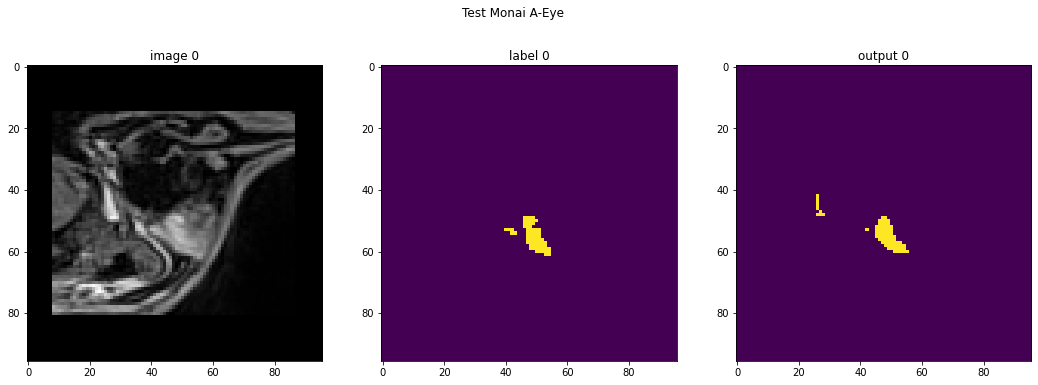

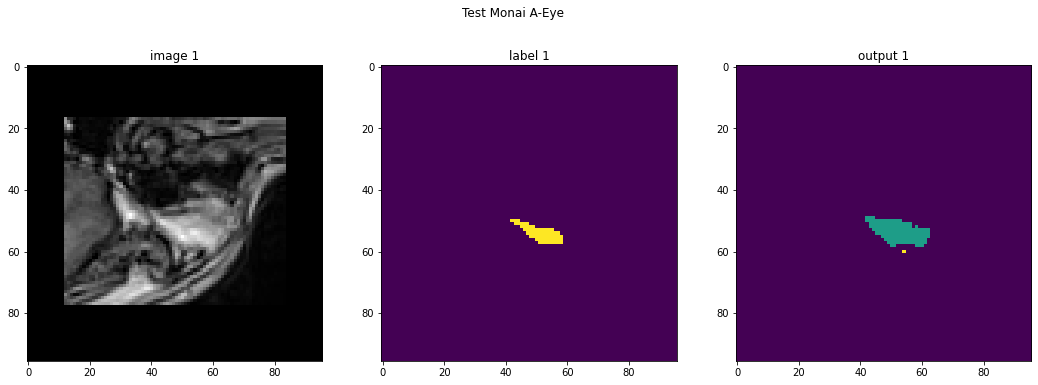

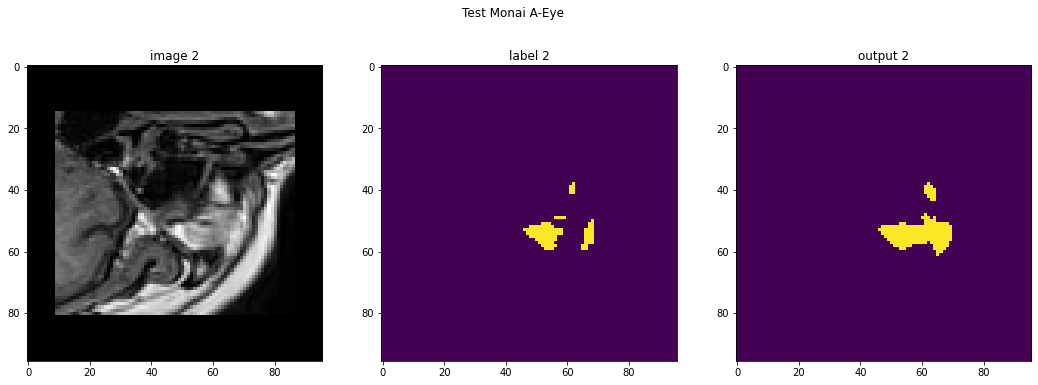

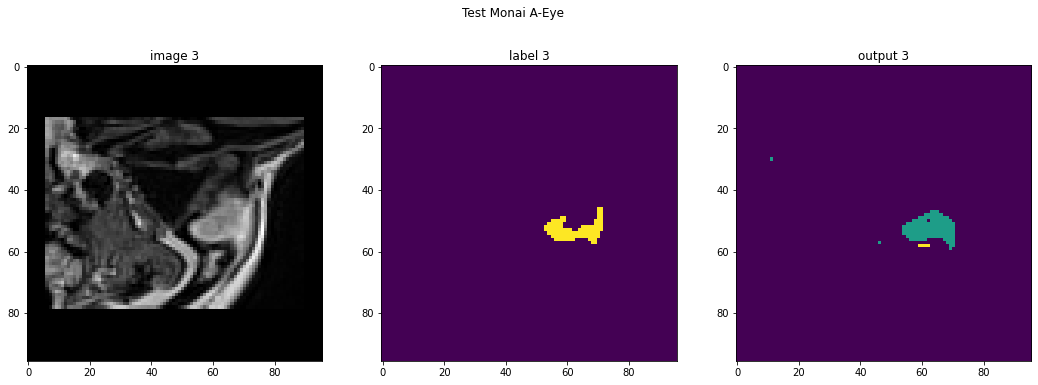

In [109]:
FILE = "best_metric_model.pth"

model.load_state_dict(torch.load(os.path.join(main_dir, FILE)))
model.eval()

with torch.no_grad():
    for i, val_data in enumerate(val_loader):       
        roi_size = (min_axis, min_axis, min_axis)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data['image'].to(device), roi_size, sw_batch_size, model)
        fig = plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 48], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 48])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 48])
        im_result = sitk.GetImageFromArray(np.transpose(torch.argmax(val_outputs, dim=1).detach().cpu().numpy(), (3,2,1,0)))
        filename = val_data['label_meta_dict']['filename_or_obj'][0].split('/')[-1].split('.')[0]
        sitk.WriteImage(im_result, main_dir + 'val_trans/' + filename + '_trans_results.nii.gz')
        # if i == 1:
        #     break
        fig.suptitle('Test Monai A-Eye')
        plt.show()

### Val on original space

##### Load val subjects list from file

In [110]:
file = main_dir + 'val_subjects.txt' # test subjects list file

val_subs = [] # empty list to read list from a file

# open file and read the content in a list
with open(file, 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]

        # add current item to the list
        val_subs.append(x)

# display list
print(val_subs)

val_images = []
val_labels = []

# Val set
for i in range(len(val_subs)):
    input_t1 = data_dir + 'a123/' + val_subs[i] + '/input/' + val_subs[i] + '_T1_cropped.nii.gz'
    input_labels = data_dir + 'a123/' + val_subs[i] + '/input/' + val_subs[i] + '_labels_cropped.nii.gz'
    val_images.append(input_t1)
    val_labels.append(input_labels)

# Val dictionary
data_val_dict = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(val_images, val_labels)
]

print(data_val_dict)

['sub-09', 'sub-15', 'sub-19', 'sub-24']
[{'image': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-09/input/sub-09_T1_cropped.nii.gz', 'label': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-09/input/sub-09_labels_cropped.nii.gz'}, {'image': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-15/input/sub-15_T1_cropped.nii.gz', 'label': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-15/input/sub-15_labels_cropped.nii.gz'}, {'image': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-19/input/sub-19_T1_cropped.nii.gz', 'label': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-19/input/sub-19_labels_cropped.nii.gz'}, {'image': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-24/input/sub-24_T1_cropped.nii.gz', 'label': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-24/input/sub-24_labels_cropped.nii.gz'}]


##### Transforms, Dataset and DataLoader

In [112]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        Lambdad(keys=["image"], func=lambda image: torch.nan_to_num(image, nan=0)),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys=["image"],),
        CropForegroundd(keys=["image"], source_key="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1, 1, 1), mode=("bilinear")),
        ResizeWithPadOrCropd(keys=["image"], spatial_size=(min_axis, min_axis, min_axis)), # (96, 96, 96)
        # masked,
    ]
)

val_org_ds = Dataset(data=data_val_dict, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=8)

post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=NUM_LABELS+1),
    AsDiscreted(keys="label", to_onehot=NUM_LABELS+1),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir=main_dir+"val_orig/", output_postfix="seg", resample=False, separate_folder=False)
])

#### Evaluation on original image spacings

2022-10-03 15:34:56,546 INFO image_writer.py:192 - writing: val_orig/sub-09_T1_cropped_seg.nii.gz
(10, 66, 79, 68)
2022-10-03 15:34:56,805 INFO image_writer.py:192 - writing: val_orig/sub-15_T1_cropped_seg.nii.gz
(10, 61, 72, 70)
2022-10-03 15:34:56,955 INFO image_writer.py:192 - writing: val_orig/sub-19_T1_cropped_seg.nii.gz
(10, 66, 78, 66)
2022-10-03 15:34:57,134 INFO image_writer.py:192 - writing: val_orig/sub-24_T1_cropped_seg.nii.gz
(10, 62, 84, 68)
Total averaged DSC is 0.7565361857414246. 
Total averaged IoU score is 0.6177937984466553.
Mean dice per class: [0.7619277238845825, 0.9014095664024353, 0.7490630149841309, 0.6891375184059143, 0.6690143942832947, 0.7884014844894409, 0.7270880937576294, 0.774960994720459, 0.7478222846984863]
Mean IoU per class: [0.623007595539093, 0.8220115900039673, 0.6007201671600342, 0.5388200283050537, 0.5033923387527466, 0.6524533629417419, 0.5863606929779053, 0.632766842842102, 0.6006113290786743]


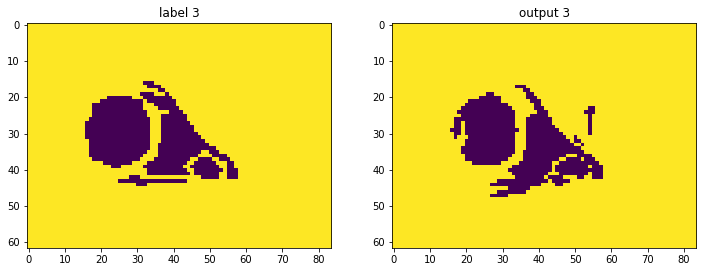

In [113]:
model.load_state_dict(torch.load(os.path.join(main_dir, FILE)))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (min_axis, min_axis, min_axis)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)

        # Metrics
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        print(val_outputs[0].shape)
        dice_metric(y_pred=val_outputs, y=val_labels)
        iou_metric(y_pred=val_outputs, y=val_labels)
        # Plot
        fig = plt.figure("check", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"label {i}")
        plt.imshow(val_labels[0].detach().cpu()[0, :, :, 32]) # shape = (10, x, y, z), being 0 the background and 1-9 the labels
        plt.subplot(1, 2, 2)
        plt.title(f"output {i}")
        plt.imshow(val_outputs[0].detach().cpu()[0, :, :, 32]) # shape = (10, x, y, z), being 0 the background and 1-9 the labels

    # aggregate the final mean dice and IoU results
    dice_array = dice_metric.get_buffer()
    avg_dice = dice_metric.aggregate().item()
    dice_metric.reset() # reset the status for next round
    iou_array = iou_metric.get_buffer()
    avg_iou = iou_metric.aggregate().item()    
    iou_metric.reset() # reset the status for next round

    print(f"Total averaged DSC is {avg_dice}. \nTotal averaged IoU score is {avg_iou}.")
    
    # DSC per class
    dice_array_n = dice_array.transpose(0, 1) # to get in each line the DSC of each class
    dice_array_mean = []
    for i, val in enumerate(dice_array_n):
        dice_array_mean.append(torch.mean(val).item())
    print(f'Mean dice per class: {dice_array_mean}')

    # IoU per class
    iou_array_n = iou_array.transpose(0, 1) # to get in each line the IoU of each class
    iou_array_mean = []
    for i, val in enumerate(iou_array_n):
        iou_array_mean.append(torch.mean(val).item())
    print(f'Mean IoU per class: {iou_array_mean}')

#### Get results in intensities, not components

In [114]:
output_dir = './val_orig/'
segments = [nib.load(f) for f in Path(output_dir).rglob('*seg.nii.gz')]
for i in range(len(segments)):
    multi_label = np.zeros((segments[i].shape[0], segments[i].shape[1], segments[i].shape[2]))
    for j in range(segments[i].shape[-1]): # 0-9
        multi_label[segments[i].get_fdata()[..., j] == 1] = j
    im = nib.Nifti1Image(multi_label, None, None)
    path = segments[i].get_filename().split('/')[1]
    filename = segments[i].get_filename().split('/')[-1].split('.')[0]
    im.to_filename(output_dir + filename + '_res.nii.gz')

### Test on transformed space

#### Load test subjects list from file (images and labels)

In [124]:
file = main_dir + 'test_subjects.txt' # test subjects list file

test_subs = [] # empty list to read list from a file

# open file and read the content in a list
with open(file, 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]

        # add current item to the list
        test_subs.append(x)

# display list
print(test_subs)

# Test Set
test_images = []
test_labels = []

# Test set
for i in range(len(test_subs)):
    input_t1 = data_dir + 'a123/' + test_subs[i] + '/input/' + test_subs[i] + '_T1_cropped.nii.gz'
    input_labels = data_dir + 'a123/' + test_subs[i] + '/input/' + test_subs[i] + '_labels_cropped.nii.gz'
    test_images.append(input_t1)
    test_labels.append(input_labels)

# Test dictionary
data_test_dict = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(test_images, test_labels)
]

num_test_samples = len(data_test_dict)
print(f"Test set composed by {num_test_samples} subjects ({num_test_samples/num_total_subjects*100:.2f}%).")

['sub-13', 'sub-14', 'sub-21', 'sub-34']
Test set composed by 4 subjects (11.43%).


#### Transforms, Dataset and DataLoader

In [125]:
# Function to crop the eye from the medical image
def masked(data_dict):
    eye_mask = (data_dict["label"] != 0)
    eye_mask[eye_mask == True] = 1
    eye_mask[eye_mask == False] = 0
    data_dict["image"] = data_dict["image"] * eye_mask

    return data_dict

test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        Lambdad(keys=["image"], func=lambda image: torch.nan_to_num(image, nan=0)),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys=["image"],),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")),
        ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(min_axis, min_axis, min_axis)), # (96, 96, 96)
        # masked,
        SaveImaged(keys="image", output_dir=main_dir+"test_trans/", output_postfix="trans", resample=False, separate_folder=False),
        SaveImaged(keys="label", output_dir=main_dir+"test_trans/", output_postfix="trans", resample=False, separate_folder=False)
    ]
)

test_ds = Dataset(data=data_test_dict, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

#### Check transforms in DataLoader

2022-10-03 15:36:38,111 INFO image_writer.py:192 - writing: test_trans/sub-13_T1_cropped_trans.nii.gz
2022-10-03 15:36:38,134 INFO image_writer.py:192 - writing: test_trans/sub-13_labels_cropped_trans.nii.gz
image shape: (1, 1, 96, 96, 96), label shape: (1, 1, 96, 96, 96)
torch unique label: 10


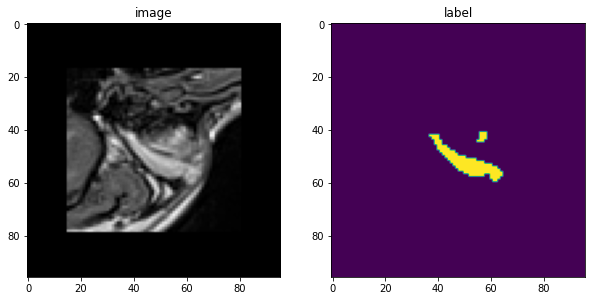

In [117]:
check_data = first(test_loader)
image, label = (check_data["image"], check_data["label"])
print(f"image shape: {image.shape}, label shape: {label.shape}")
print(f'torch unique label: {len(torch.unique(label))}')

plt.figure("check", (10,5))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0, 0, :, :, 48], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, 0, :, :, 48])
plt.show()

# Save transformed image
# im_trans = sitk.GetImageFromArray(np.transpose(image[0].detach().cpu().numpy(), (3,2,1,0)))
# sitk.WriteImage(im_trans, main_dir+'im_trans.nii.gz')
# lab_trans = sitk.GetImageFromArray(np.transpose(label[0].detach().cpu().numpy(), (3,2,1,0)))
# sitk.WriteImage(lab_trans, main_dir+'lab_trans.nii.gz')

#### Save transformed images from loader set

In [ ]:
'''
output_dir = main_dir+'test_trans/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Saving check_loader images
i = 1
for _, dict in enumerate(test_loader):
    # print(f"dict: {dict['image'].shape}")
    im_tensors = dict['image']
    lab_tensors = dict['label']
    # print(im_tensors[0].detach().cpu().numpy().shape)
    # print(lab_tensors[0].detach().cpu().numpy().shape)
    im_trans = sitk.GetImageFromArray(np.transpose(im_tensors[0].detach().cpu().numpy(), (3,2,1,0)))
    sitk.WriteImage(im_trans, output_dir+'im_trans'+str(i)+'.nii.gz')
    lab_trans = sitk.GetImageFromArray(np.transpose(lab_tensors[0].detach().cpu().numpy(), (3,2,1,0)))
    sitk.WriteImage(lab_trans, output_dir+'lab_trans'+str(i)+'.nii.gz')
    i += 1
    # if i == 1:
    #     break
# '''

#### Inference, Plots and Metrics

2022-10-03 15:44:30,702 INFO image_writer.py:192 - writing: test_trans/sub-13_T1_cropped_trans.nii.gz
2022-10-03 15:44:30,728 INFO image_writer.py:192 - writing: test_trans/sub-13_labels_cropped_trans.nii.gz
2022-10-03 15:44:31,080 INFO image_writer.py:192 - writing: test_trans/sub-14_T1_cropped_trans.nii.gz
2022-10-03 15:44:31,104 INFO image_writer.py:192 - writing: test_trans/sub-14_labels_cropped_trans.nii.gz
2022-10-03 15:44:31,402 INFO image_writer.py:192 - writing: test_trans/sub-21_T1_cropped_trans.nii.gz
2022-10-03 15:44:31,427 INFO image_writer.py:192 - writing: test_trans/sub-21_labels_cropped_trans.nii.gz
2022-10-03 15:44:31,720 INFO image_writer.py:192 - writing: test_trans/sub-34_T1_cropped_trans.nii.gz
2022-10-03 15:44:31,745 INFO image_writer.py:192 - writing: test_trans/sub-34_labels_cropped_trans.nii.gz
Total averaged DSC is 0.7847827076911926. 
Total averaged IoU score is 0.6512933969497681.
Mean dice per class: [0.7593346834182739, 0.8973315954208374, 0.7311317920684

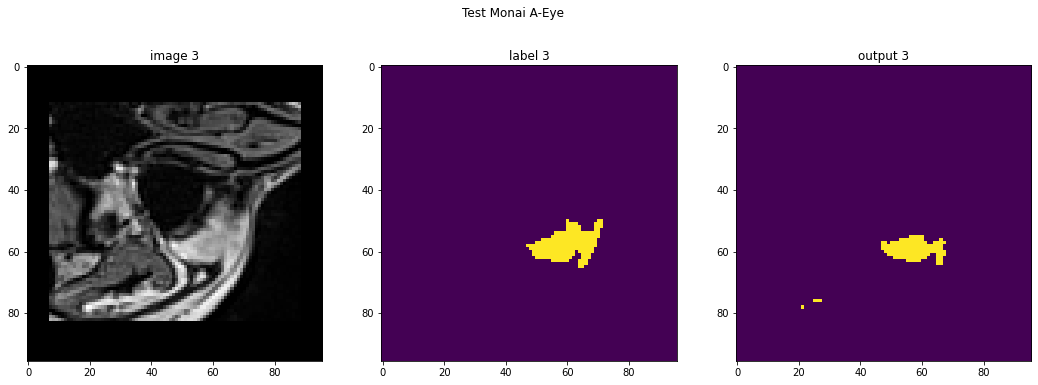

In [126]:
from fileinput import filename

# Post tranformations to calculate the metrics
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=NUM_LABELS+1)])
post_label = Compose([AsDiscrete(to_onehot=NUM_LABELS+1)])

model.eval()

with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        test_inputs, test_labels = (
            test_data["image"].to(device),
            test_data["label"].to(device),
        )

        roi_size = (min_axis, min_axis, min_axis)
        sw_batch_size = 4

        test_outputs_pre = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model
        )

        test_outputs = [post_pred(j) for j in decollate_batch(test_outputs_pre)]
        test_labels = [post_label(j) for j in decollate_batch(test_labels)]
        iou_metric(y_pred=test_outputs, y=test_labels)
        dice_metric(y_pred=test_outputs, y=test_labels)

        # plot the slice [:, :, 80]
        fig = plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_data["image"][0, 0, :, :, 32], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_data["label"][0, 0, :, :, 32])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(test_outputs_pre, dim=1).detach().cpu()[0, :, :, 32])
        # plt.imshow(test_outputs[0].detach().cpu()[0, :, :, 32])
        im_result = sitk.GetImageFromArray(np.transpose(torch.argmax(test_outputs_pre, dim=1).detach().cpu().numpy(), (3,2,1,0)))
        im_result = sitk.GetImageFromArray(np.transpose(test_outputs[0].detach().cpu().numpy(), (3,2,1,0)))
        filename = test_data['label_meta_dict']['filename_or_obj'][0].split('/')[-1].split('.')[0]
        sitk.WriteImage(im_result, main_dir + 'test_trans/' + filename + '_trans_results' + '.nii.gz')
        # if i == 1:
        #     break
        fig.suptitle('Test Monai A-Eye')
        # plt.show()
    
    # aggregate the final mean dice and IoU results
    dice_array = dice_metric.get_buffer()
    avg_dice = dice_metric.aggregate().item()
    dice_metric.reset() # reset the status for next round
    iou_array = iou_metric.get_buffer()
    avg_iou = iou_metric.aggregate().item()    
    iou_metric.reset() # reset the status for next round

    print(f"Total averaged DSC is {avg_dice}. \nTotal averaged IoU score is {avg_iou}.")
    
    # DSC per class
    dice_array_n = dice_array.transpose(0, 1) # to get in each line the DSC of each class
    dice_array_mean = []
    for i, val in enumerate(dice_array_n):
        dice_array_mean.append(torch.mean(val).item())
    print(f'Mean dice per class: {dice_array_mean}')

    # IoU per class
    iou_array_n = iou_array.transpose(0, 1) # to get in each line the IoU of each class
    iou_array_mean = []
    for i, val in enumerate(iou_array_n):
        iou_array_mean.append(torch.mean(val).item())
    print(f'Mean IoU per class: {iou_array_mean}')

### Test on original space

#### Load test subjects list from file and create list of test images (WITH LABELS)

In [11]:
file = main_dir + 'test_subjects.txt' # test subjects list file

test_subs = [] # empty list to read list from a file

# open file and read the content in a list
with open(file, 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]

        # add current item to the list
        test_subs.append(x)

# display list
print(test_subs)

# Test Set
test_images = []
test_labels = []

# Test set
for i in range(len(test_subs)):
    input_t1 = data_dir + 'a123/' + test_subs[i] + '/input/' + test_subs[i] + '_T1_cropped.nii.gz'
    input_labels = data_dir + 'a123/' + test_subs[i] + '/input/' + test_subs[i] + '_labels_cropped.nii.gz'
    test_images.append(input_t1)
    test_labels.append(input_labels)

# Test dictionary
data_test_dict = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(test_images, test_labels)
]

num_test_samples = len(data_test_dict)
print(f"Test set composed by {num_test_samples} subjects ({num_test_samples/num_total_subjects*100:.2f}%).")

['sub-13', 'sub-14', 'sub-21', 'sub-34']
Test set composed by 4 subjects (11.43%).


#### Transforms, Dataset, DataLoader and Post Transforms

In [13]:
test_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        Lambdad(keys=["image"], func=lambda image: torch.nan_to_num(image, nan=0)),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys=["image"],),
        CropForegroundd(keys=["image"], source_key="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1, 1, 1), mode=("bilinear")),
        ResizeWithPadOrCropd(keys=["image"], spatial_size=(min_axis, min_axis, min_axis)), # (96, 96, 96)
        # masked,
    ]
)

test_org_ds = Dataset(data=data_test_dict, transform=test_org_transforms)
test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=8)

post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=NUM_LABELS+1),
    AsDiscreted(keys="label", to_onehot=NUM_LABELS+1),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir=main_dir+"test_orig", output_postfix="seg", resample=False, separate_folder=False)
])

#### Evaluation on original image spacings

2022-10-26 12:05:17,876 INFO image_writer.py:192 - writing: /mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/test_orig_pruebas/sub-13_T1_cropped_seg.nii.gz
2022-10-26 12:05:18,099 INFO image_writer.py:192 - writing: /mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/test_orig_pruebas/sub-14_T1_cropped_seg.nii.gz
2022-10-26 12:05:18,304 INFO image_writer.py:192 - writing: /mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/test_orig_pruebas/sub-21_T1_cropped_seg.nii.gz
2022-10-26 12:05:18,467 INFO image_writer.py:192 - writing: /mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/test_orig_pruebas/sub-34_T1_cropped_seg.nii.gz
Total averaged DSC is 0.7847827076911926. 
Total averaged IoU score is 0.6512933969497681.
Mean dice per class: [0.7593346834182739, 0.8973315954208374, 0.7311317920684814, 0.8107789754867554, 0.7445533275604248, 0.7486516237258911, 0.8474248647689819, 0.8023630380630493, 0.7214739918708801]
Mean Io

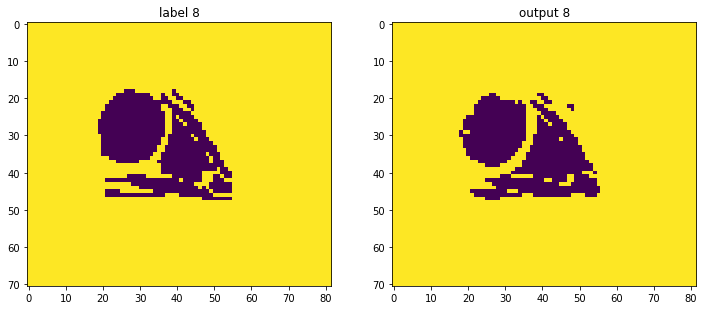

In [16]:
model.load_state_dict(torch.load(os.path.join(main_dir, FILE)))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (min_axis, min_axis, min_axis)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        # Metrics
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_outputs, test_labels = from_engine(["pred", "label"])(test_data)
        # print(test_outputs[0].shape)
        dice_metric(y_pred=test_outputs, y=test_labels)
        iou_metric(y_pred=test_outputs, y=test_labels)
        # Plot
        fig = plt.figure("check", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"label {i}")
        plt.imshow(test_labels[0].detach().cpu()[0, :, :, 32]) # shape = (10, x, y, z), being 0 the background and 1-9 the labels
        plt.subplot(1, 2, 2)
        plt.title(f"output {i}")
        plt.imshow(test_outputs[0].detach().cpu()[0, :, :, 32]) # shape = (10, x, y, z), being 0 the background and 1-9 the labels

    # aggregate the final mean dice and IoU results
    dice_array = dice_metric.get_buffer()
    avg_dice = dice_metric.aggregate().item()
    dice_metric.reset() # reset the status for next round
    iou_array = iou_metric.get_buffer()
    avg_iou = iou_metric.aggregate().item()    
    iou_metric.reset() # reset the status for next round

    print(f"Total averaged DSC is {avg_dice}. \nTotal averaged IoU score is {avg_iou}.")
    
    # DSC per class
    dice_array_n = dice_array.transpose(0, 1) # to get in each line the DSC of each class
    dice_array_mean = []
    for i, val in enumerate(dice_array_n):
        dice_array_mean.append(torch.mean(val).item())
    print(f'Mean dice per class: {dice_array_mean}')

    # IoU per class
    iou_array_n = iou_array.transpose(0, 1) # to get in each line the IoU of each class
    iou_array_mean = []
    for i, val in enumerate(iou_array_n):
        iou_array_mean.append(torch.mean(val).item())
    print(f'Mean IoU per class: {iou_array_mean}')

#### Get results in intensities, not in components

In [17]:
output_dir = main_dir+'test_orig/'
segments = [nib.load(f) for f in Path(output_dir).rglob('*seg.nii.gz')]
for i in range(len(segments)):
    multi_label = np.zeros((segments[i].shape[0], segments[i].shape[1], segments[i].shape[2]))
    for j in range(segments[i].shape[-1]): # 0-9
        multi_label[segments[i].get_fdata()[..., j] == 1] = j
    im = nib.Nifti1Image(multi_label, None, None)
    path = segments[i].get_filename().split('/')[1]
    filename = segments[i].get_filename().split('/')[-1].split('.')[0]
    im.to_filename(output_dir + filename + '_res.nii.gz')

#### Boxplots: write data in a .csv

In [84]:
output_dir = main_dir+'test_orig/'

dice_avg = np.zeros(dice_array.shape[0])
for i in range(dice_array.shape[0]): # nº of subjects = rows
    dice_avg[i] = np.average(dice_array[i,:])

data_dsc = [test_subs, dice_avg[:], dice_array[:,0].numpy(), dice_array[:,1].numpy(), dice_array[:,2].numpy(), dice_array[:,3].numpy(), 
    dice_array[:,4].numpy(), dice_array[:,5].numpy(), dice_array[:,6].numpy(), dice_array[:,7].numpy(), dice_array[:,8].numpy()]
data_dsc = np.array(data_dsc).T

metrics = ['Subject', 'DSC_all', 'DSC_lens','DSC_globe','DSC_nerve','DSC_int_fat','DSC_ext_fat','DSC_lat_mus','DSC_med_mus','DSC_inf_mus','DSC_sup_mus']

with open(output_dir + 'data_dsc_test.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(metrics)
    writer.writerows(data_dsc)

#### Boxplots: read .csv as dataframe and plot results

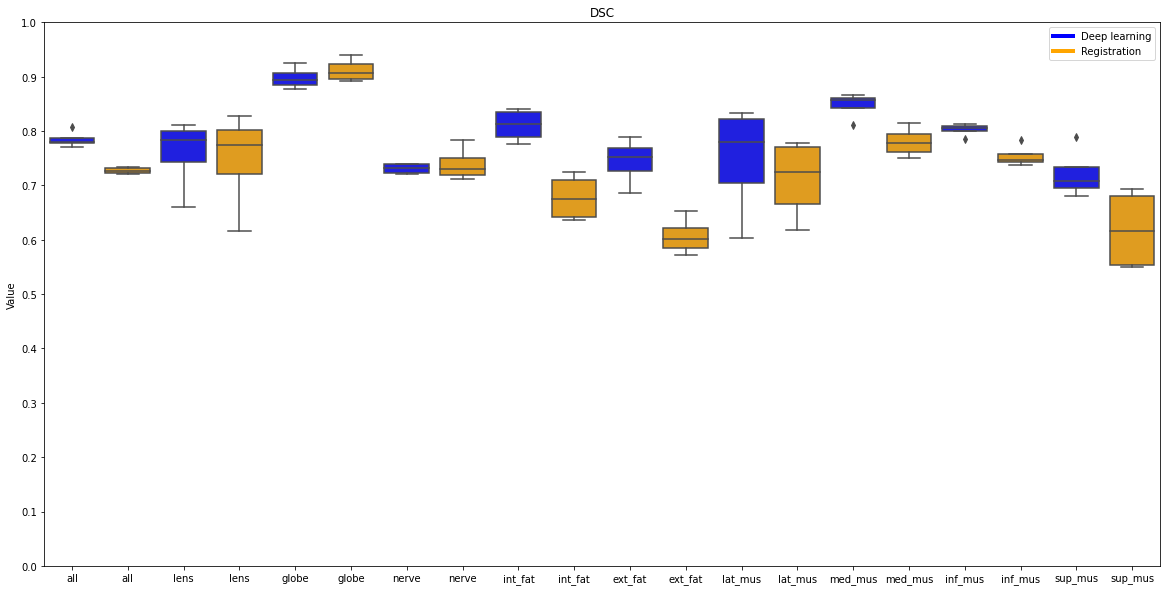

In [41]:
from matplotlib.pyplot import Line2D

output_dir = main_dir+'test_orig/'

df = pd.read_csv(output_dir + 'data_dsc.csv')
df_reg = pd.read_csv(output_dir + 'data_dsc_reg.csv')

# df_dsc = [df['DSC_all'],  df['DSC_lens'], df['DSC_globe'], df['DSC_nerve'], df['DSC_int_fat'], df['DSC_ext_fat'], 
#             df['DSC_lat_mus'], df['DSC_med_mus'], df['DSC_inf_mus'], df['DSC_sup_mus']]
df_dsc = [df['DSC_all'], df_reg['DSC_all'], df['DSC_lens'], df_reg['DSC_lens'], df['DSC_globe'], df_reg['DSC_globe'], df['DSC_nerve'], df_reg['DSC_nerve'], 
    df['DSC_int_fat'], df_reg['DSC_int_fat'], df['DSC_ext_fat'], df_reg['DSC_ext_fat'], df['DSC_lat_mus'], df_reg['DSC_lat_mus'], 
    df['DSC_med_mus'], df_reg['DSC_med_mus'], df['DSC_inf_mus'], df_reg['DSC_inf_mus'], df['DSC_sup_mus'], df_reg['DSC_sup_mus']]

fig, axs = plt.subplots(figsize=(20,10))
fig.canvas.manager.set_window_title('DSC per label')

colours_palette = ['blue','orange','blue','orange','blue','orange','blue','orange','blue','orange','blue','orange','blue','orange','blue','orange','blue','orange','blue','orange']
ax = sns.boxplot(data=df_dsc, palette=colours_palette) # data=data_dsc, no need to create a .csv
# ax = sns.swarmplot(data=df_dsc) # data=data_dsc, no need to create a .csv

ax.set_title('DSC')
ax.set(ylabel="Value")
# ax.set_xticklabels(['all','lens','globe','nerve','int_fat','ext_fat','lat_mus','med_mus','inf_mus','sup_mus'])
ax.set_xticklabels(['all','all','lens','lens','globe','globe','nerve','nerve','int_fat','int_fat','ext_fat','ext_fat','lat_mus','lat_mus','med_mus','med_mus','inf_mus','inf_mus','sup_mus','sup_mus'])
ax.set_yticks(np.arange(0, 1.1, 0.1))

# Legend
legend_elements = [Line2D([0], [0], color='blue', lw=4, label='Deep learning'),
Line2D([0], [0], color='orange', lw=4, label='Registration')]
ax.legend(handles=legend_elements)

### Pure testing (no labels) on original space

#### Load test subjects list from file and create list of test images (no labels)

In [45]:
file = main_dir + 'test_subjects.txt' # test subjects list file

test_subs = [] # empty list to read list from a file

# open file and read the content in a list
with open(file, 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]

        # add current item to the list
        test_subs.append(x)

# display list
print(test_subs)

# Test Set (now it's not a dictionary, no labels)
test_images = []
for i in range(len(test_subs)):
    input_t1 = data_dir + 'a123/' + test_subs[i] + '/input/' + test_subs[i] + '_T1.nii.gz'
    test_images.append(input_t1)
test_data = [{"image": image} for image in test_images]

print(test_data)

['sub-13', 'sub-14', 'sub-21', 'sub-34']
[{'image': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-13/input/sub-13_T1.nii.gz'}, {'image': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-14/input/sub-14_T1.nii.gz'}, {'image': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-21/input/sub-21_T1.nii.gz'}, {'image': '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/a123/sub-34/input/sub-34_T1.nii.gz'}]


#### Load pure test subjects == non-labeled

In [9]:
# Test Set (now it's not a dictionary, no labels)
pure_test_path = '/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/non_labeled_dataset_nifti_cropped/'
output_dir = main_dir + "test_orig_reg-cropped_non-labeled/"
test_images = [img for img in sorted(os.listdir(pure_test_path)) if img.split('.')[0]+'_seg.nii.gz' not in list(sorted(os.listdir(output_dir)))]
test_data = [{"image": pure_test_path+image} for image in test_images]
print(len(test_data))

1110


#### Transforms, Dataset, DataLoader and Post Transforms

In [10]:
test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        Lambdad(keys="image", func=lambda image: torch.nan_to_num(image, nan=0)),
        EnsureChannelFirstd(keys="image"),
        ScaleIntensityd(keys=["image"],),
        CropForegroundd(keys=["image"], source_key="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1, 1, 1), mode=("bilinear")),
        # ResizeWithPadOrCropd(keys=["image"], spatial_size=(min_axis, min_axis, min_axis)),
        # masked,
    ]
)

test_org_ds = Dataset(data=test_data, transform=test_org_transforms)
test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=NUM_LABELS+1),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir=main_dir+"test_orig_reg-cropped_non-labeled", output_postfix="seg", resample=False, separate_folder=False),
])

#### Inference on Test Set

In [11]:
model.load_state_dict(torch.load(os.path.join(main_dir, FILE)))
model.eval()

loader = LoadImage() # to visualize predicted results

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, predictor=model)
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

        # # Plot
        # test_output = from_engine(["pred"])(test_data)
        # original_image = loader(test_output[0].meta["filename_or_obj"])
        # plt.figure("check", (18, 6))
        # plt.subplot(1, 2, 1)
        # plt.imshow(original_image[0][:, :, 32], cmap="gray")
        # plt.subplot(1, 2, 2)
        # plt.imshow(test_output[0].detach().cpu()[0, :, :, 32])
        # plt.show()

2022-10-31 11:05:27,188 INFO image_writer.py:192 - writing: /mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/test_orig_reg-cropped_non-labeled/2022160100311_cropped_seg.nii.gz
2022-10-31 11:05:27,334 INFO image_writer.py:192 - writing: /mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/test_orig_reg-cropped_non-labeled/2022160100312_cropped_seg.nii.gz
2022-10-31 11:05:27,488 INFO image_writer.py:192 - writing: /mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/test_orig_reg-cropped_non-labeled/2022160100318_cropped_seg.nii.gz
2022-10-31 11:05:27,634 INFO image_writer.py:192 - writing: /mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/test_orig_reg-cropped_non-labeled/2022160100323_cropped_seg.nii.gz
2022-10-31 11:05:27,734 INFO image_writer.py:192 - writing: /mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/experiment_0/test_orig_reg-cropped_non-labeled/2022160100325_cropped_seg.nii.gz
2022-10-31 11:05:27,825 I

#### Get results in intensities, not in components

In [12]:
# output_dir = main_dir + 'test_orig_reg-cropped_non-labeled/'
segments = [nib.load(f) for f in Path(output_dir).rglob('*seg.nii.gz')]
for i in range(len(segments)):
    multi_label = np.zeros((segments[i].shape[0], segments[i].shape[1], segments[i].shape[2]))
    for j in range(segments[i].shape[-1]): # 0-9
        multi_label[segments[i].get_fdata()[..., j] == 1] = j
    im = nib.Nifti1Image(multi_label, None, None)
    path = segments[i].get_filename().split('/')[1]
    filename = segments[i].get_filename().split('/')[-1].split('.')[0]
    im.to_filename(output_dir + filename + '_res.nii.gz')